In [13]:
import torch
import torch.nn as nn
import scipy.io
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from FNO_inverse import FNO2dInverseClassifier 
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# データ読み込み
train_data = torch.load('data/datasets/data/darcy_train_16.pt')
test_data_16 = torch.load('data/datasets/data/darcy_test_16.pt')
test_data_32 = torch.load('data/datasets/data/darcy_test_32.pt')
print(train_data.keys())

dict_keys(['x', 'y'])


/var/folders/k3/b1t1gjg12pg0ycfdgpm2k7g00000gn/T/ipykernel_47771/1827043217.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load('data/datasets/data/

In [14]:
x_train, y_train = train_data['y'], train_data['x']
x_test, y_test = test_data_16['y'], test_data_16['x']
x_train = x_train.unsqueeze(-1) 
x_test = x_test.unsqueeze(-1)
y_train = y_train.unsqueeze(-1)  # (B, H, W) → (B, H, W, 1)
y_test = y_test.unsqueeze(-1)


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
x_train = x_train.float().to(device)
y_train = y_train.float().to(device)
x_test = x_test.float().to(device)
y_test = y_test.float().to(device)
print(x_train.shape)  # → torch.Size([100, 1, 16, 16]) を想定
print(y_train.shape)  # 同上

batch_size = 16
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)


torch.Size([1000, 16, 16, 1])
torch.Size([1000, 16, 16, 1])


In [ ]:
model = FNO2dInverseClassifier(8,8,32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

# --- 学習ループ ---
num_epochs = 100
patience = 10
best_val_loss = float("inf")
wait = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * xb.size(0)
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            total_val_loss += loss.item() * xb.size(0)
    avg_val_loss = total_val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4e}, Val Loss = {avg_val_loss:.4e}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        wait = 0
        torch.save(model.state_dict(), "best_FNO_inverse_model.pth")
        
        
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch}")
            break




Epoch 0: Train Loss = 5.3672e-01, Val Loss = 4.4206e-01
Epoch 1: Train Loss = 4.1058e-01, Val Loss = 3.5709e-01
Epoch 2: Train Loss = 3.0089e-01, Val Loss = 2.6498e-01
Epoch 3: Train Loss = 2.6337e-01, Val Loss = 2.5255e-01
Epoch 4: Train Loss = 2.5424e-01, Val Loss = 2.4838e-01
Epoch 5: Train Loss = 2.4738e-01, Val Loss = 2.4305e-01
Epoch 6: Train Loss = 2.3811e-01, Val Loss = 2.3313e-01
Epoch 7: Train Loss = 2.2897e-01, Val Loss = 2.2315e-01
Epoch 8: Train Loss = 2.1997e-01, Val Loss = 2.1523e-01
Epoch 9: Train Loss = 2.1179e-01, Val Loss = 2.1060e-01
Epoch 10: Train Loss = 2.0515e-01, Val Loss = 2.0502e-01
Epoch 11: Train Loss = 1.9927e-01, Val Loss = 2.0185e-01
Epoch 12: Train Loss = 1.9376e-01, Val Loss = 1.9721e-01
Epoch 13: Train Loss = 1.8979e-01, Val Loss = 1.9443e-01
Epoch 14: Train Loss = 1.8486e-01, Val Loss = 1.9203e-01
Epoch 15: Train Loss = 1.8198e-01, Val Loss = 1.9161e-01
Epoch 16: Train Loss = 1.7866e-01, Val Loss = 1.8632e-01
Epoch 17: Train Loss = 1.7713e-01, Val Lo

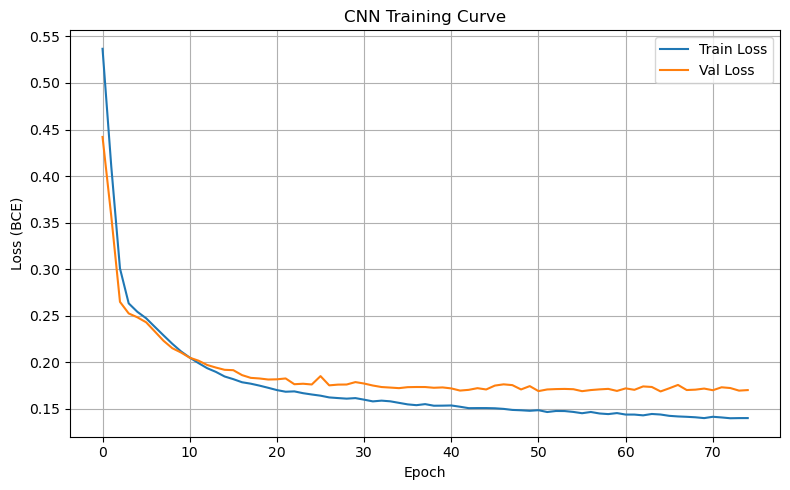

In [ ]:
# #学習曲線の可視化

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (BCE)")
plt.title("FNO_inverse Training Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("training_curve.png")  # ← 描画せず保存！

In [22]:
print(x_test.shape)

torch.Size([50, 16, 16, 1])


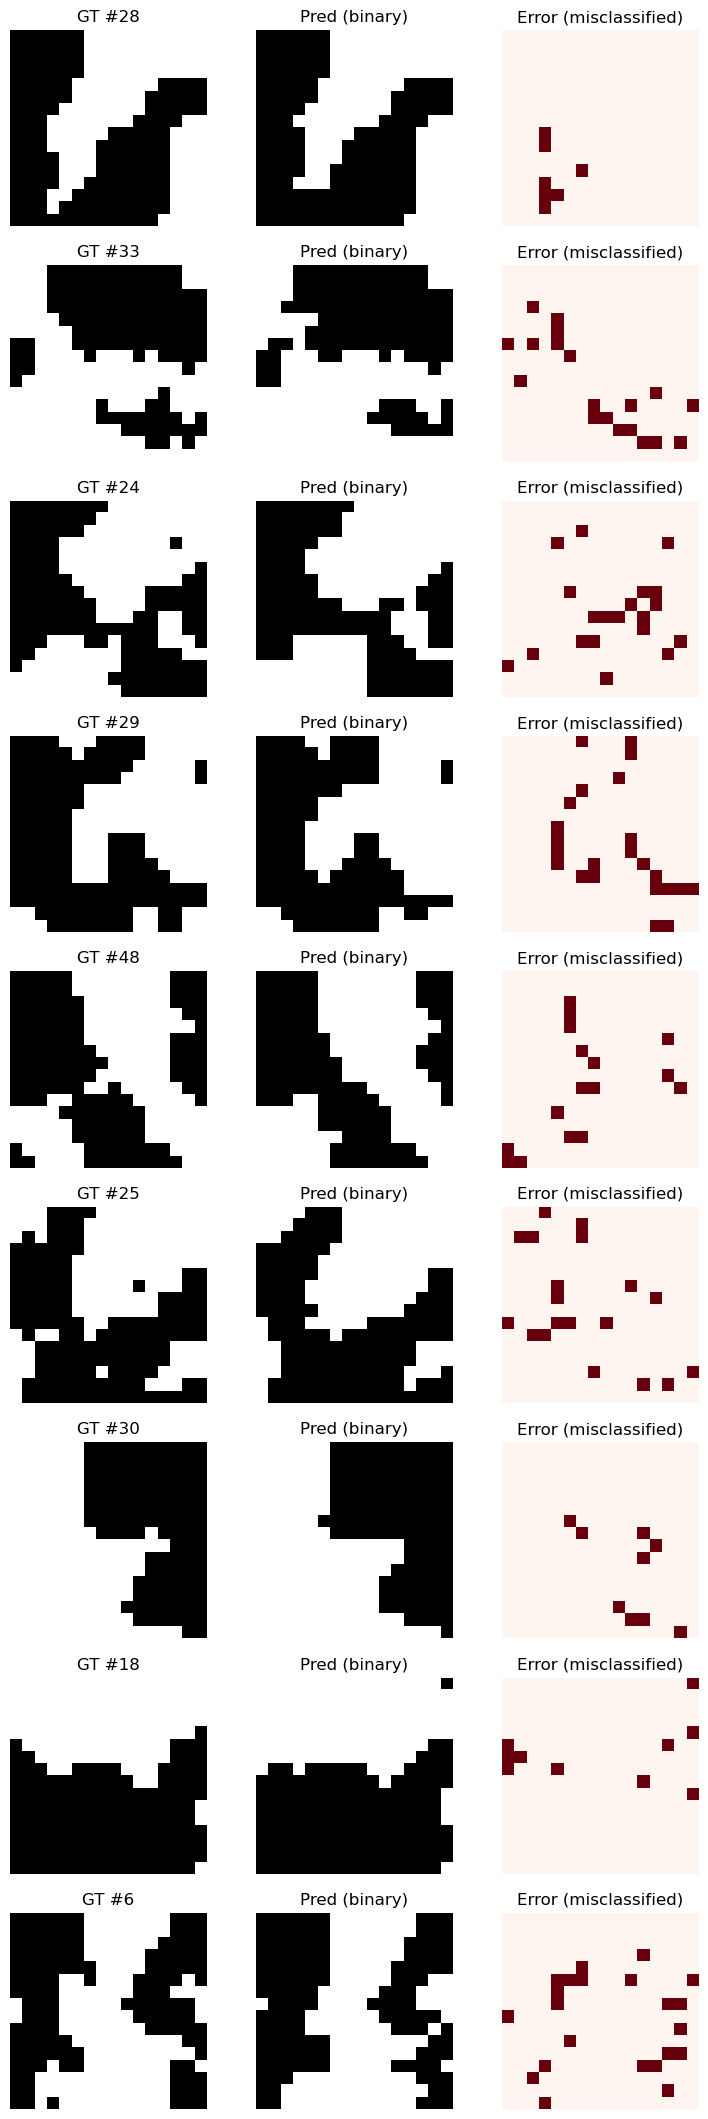

In [29]:
model.eval()
with torch.no_grad():
    pred_test = model(x_test)  # [B, H, W, 1]

# 後処理
p = pred_test.cpu().numpy()        # [B, H, W, 1]
y = y_test.cpu().numpy()           # [B, 1, H, W]

# 軸整形（squeezeで [B, H, W] に）
p = p.squeeze(-1)
y = y

num_samples = 9
indices = np.random.choice(len(y), size=num_samples, replace=False)

fig, axs = plt.subplots(num_samples, 3, figsize=(9, 3 * num_samples))

for i, idx in enumerate(indices):
    gt = y[idx].squeeze()              # [H, W]
    prob = p[idx].squeeze()            # [H, W]
    binary_pred = (prob > 0.5).astype(np.float32)
    err = np.abs(gt - binary_pred)     # [H, W]

    axs[i, 0].imshow(gt, cmap='gray')
    axs[i, 0].set_title(f"GT #{idx}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(binary_pred, cmap='gray')
    axs[i, 1].set_title("Pred (binary)")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(err, cmap='Reds', vmin=0, vmax=1)
    axs[i, 2].set_title("Error (misclassified)")
    axs[i, 2].axis('off')

